In [1]:
import pandas as pd
df = pd.read_excel(r"C:\Users\Jagan\Downloads\Online Retail.xlsx", engine='openpyxl')#data loadded
print (df.columns) #Structer view
df.head()


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [3]:
#Cleaing
df=df.dropna(subset=['CustomerID'])#drop rows with missing cid
df=df[df['Quantity']>0]#drop neg quantities
df=df[~df['InvoiceNo'].astype(str).str.startswith("C")]#drop cancel order
df=df.dropna(subset=['Description'])#drop missing rows (dis)
df['CustomerID']=df['CustomerID'].astype(int)#cid to int
df.info()#checing

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int32         
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 25.8+ MB


In [4]:
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [5]:
df['TotalPrice']=df['Quantity']*df['UnitPrice']#finding total price
df[['Quantity','UnitPrice','TotalPrice']].head()#verification

,Quantity,UnitPrice,TotalPrice
0,6,2.55,15.30
1,6,3.39,20.34
2,8,2.75,22.00
3,6,3.39,20.34
4,6,3.39,20.34


In [6]:
df['InvoiceMonth']=df["InvoiceDate"].dt.to_period('M')#month column creation
monthly_revenue=df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()#grp by sum and month
monthly_revenue['InvoiceMonth']=monthly_revenue['InvoiceMonth'].dt.to_timestamp()#period to date

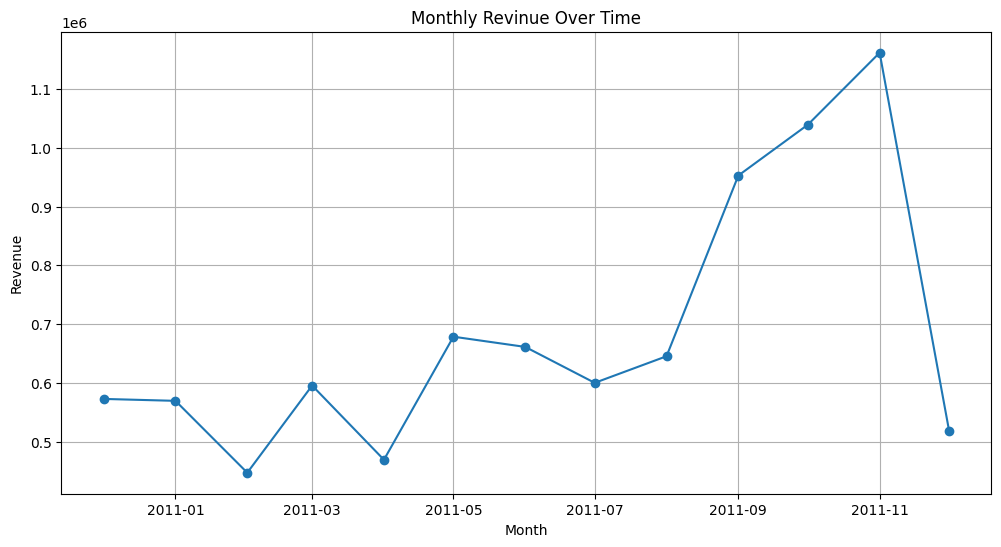

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot (monthly_revenue['InvoiceMonth'],monthly_revenue['TotalPrice'],marker='o')
plt.title('Monthly Revinue Over Time')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [8]:
df['InoviceDate']=pd.to_datetime(df['InvoiceDate'])#convert id to date(safety purpose)
latest_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)#reference date 1
rfm=df.groupby('CustomerID').agg({
    'InoviceDate':lambda x:(latest_date - x.max()).days,#recency
    'InvoiceNo':'nunique',#frequency
    'TotalPrice':'sum'#monetary
}).reset_index()#group cid
rfm.columns=['CustomerID','Rency','Frequenncy','Montery']#rename column
rfm.head()#display sample

,CustomerID,Rency,Frequenncy,Montery
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
rfm_features=rfm[['Rency','Frequenncy','Montery']]#select RFM features
scaler=StandardScaler()#scale
rfm_scaled=scaler.fit_transform(rfm_features)

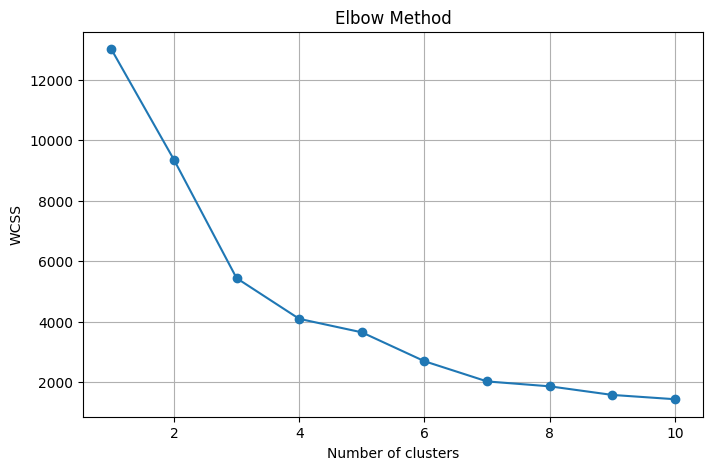

In [10]:
import matplotlib.pyplot as plt

# Elbow method to choose k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [11]:
import pandas as pd
import datetime as dt

# Assuming your cleaned DataFrame is named 'df'
# Set reference date for Recency calculation (1 day after the last InvoiceDate)
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Check result
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        2          7   4310.00
2       12348       75          4   1797.24
3       12349       19          1   1757.55
4       12350      310          1    334.40


In [12]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [14]:
rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(1)


,Recency,Frequency,Monetary,CustomerID
Cluster,,,,
0,15.7,22.0,12453.2,211
1,248.6,1.6,478.1,1062
2,7.4,82.7,127338.3,13
3,43.9,3.7,1349.7,3053


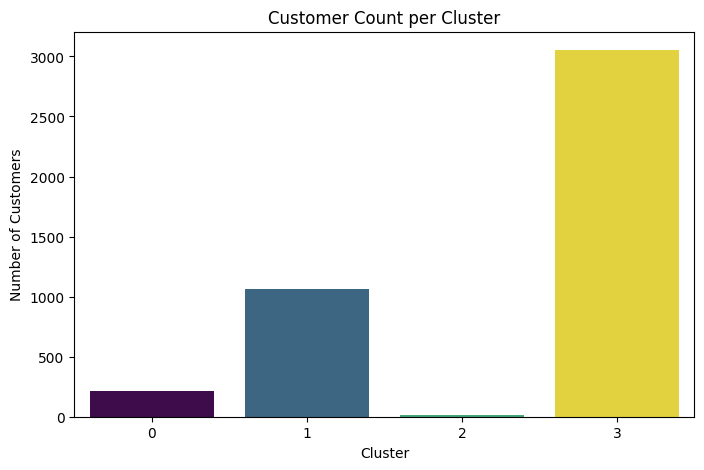

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=rfm, x='Cluster', hue='Cluster', palette='viridis', legend=False)
plt.title('Customer Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()


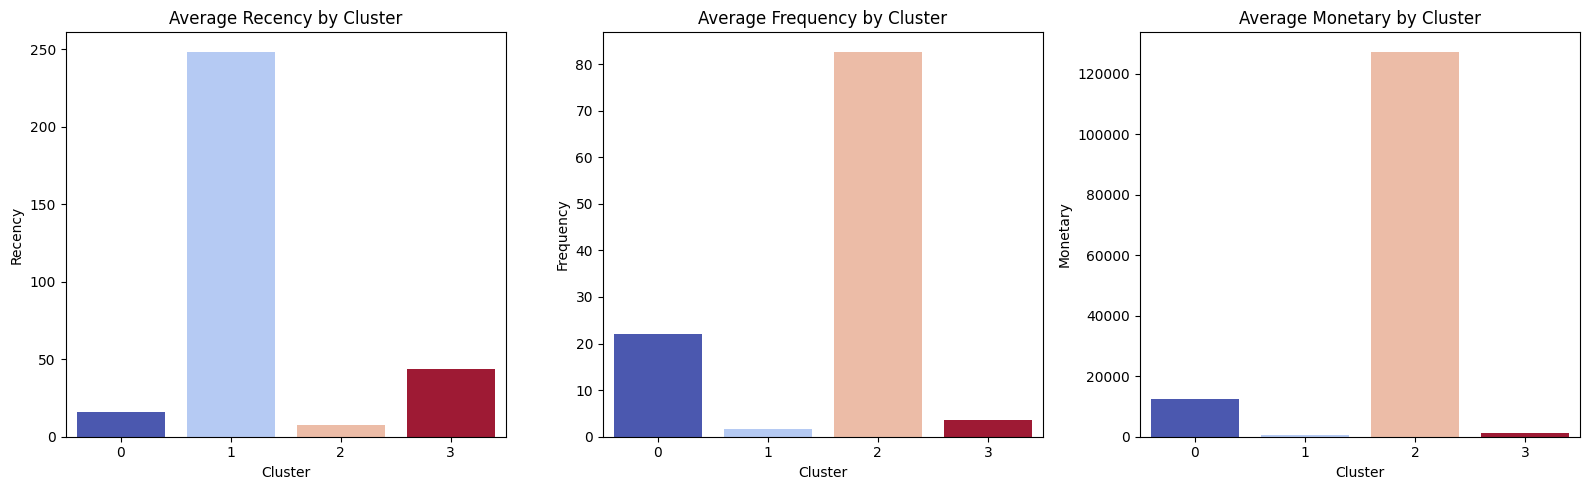

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Group RFM by Cluster
rfm_grouped = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Step 2: Plot bar charts for each RFM metric
plt.figure(figsize=(16, 5))

# Recency
plt.subplot(1, 3, 1)
sns.barplot(x='Cluster', y='Recency', hue='Cluster', data=rfm_grouped, palette='coolwarm', legend=False)
plt.title('Average Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')

# Frequency
plt.subplot(1, 3, 2)
sns.barplot(x='Cluster', y='Frequency', hue='Cluster', data=rfm_grouped, palette='coolwarm', legend=False)
plt.title('Average Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')

# Monetary
plt.subplot(1, 3, 3)
sns.barplot(x='Cluster', y='Monetary', hue='Cluster', data=rfm_grouped, palette='coolwarm', legend=False)
plt.title('Average Monetary by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary')

plt.tight_layout()
plt.show()


In [17]:
user_item_matrix = df.pivot_table(index='CustomerID',columns='Description',values='Quantity',aggfunc='sum').fillna(0)

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
user_item_scaled=scaler.fit_transform(user_item_matrix)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(user_item_scaled)

In [20]:
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

def recommend_similar_users(customer_id, n=15):
    similar_users = similarity_df[customer_id].sort_values(ascending=False)[1:n+1]
    return similar_users

In [21]:
user_item_matrix=df.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum'
).fillna(0)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
user_item_scaled = scaler.fit_transform(user_item_matrix)

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(user_item_scaled)
similarity_df = pd.DataFrame(similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

In [24]:
def recommend_similar_users(customer_id, n=5):
    if customer_id not in similarity_df.index:
        return f"CustomerID {customer_id} not found"
    similar_users = similarity_df[customer_id].sort_values(ascending=False)[1:n+1]
    return similar_users


In [25]:
def recommend_products(customer_id, n_users=5):
    similar_users = recommend_similar_users(customer_id, n=n_users)
    
    if isinstance(similar_users, str):  # error message
        return similar_users
    
    similar_user_ids = similar_users.index
    recommended_data = df[df['CustomerID'].isin(similar_user_ids)]
    
    top_products = (
        recommended_data.groupby('Description')['Quantity']
        .sum()
        .sort_values(ascending=False)
        .head(5)
    )
    return top_products


In [26]:
recommend_products(12347.0)


Description
BOOM BOX SPEAKER BOYS                  50
POPCORN HOLDER                         48
RED TOADSTOOL LED NIGHT LIGHT          24
SET OF 60 PANTRY DESIGN CAKE CASES     24
VINTAGE SNAP CARDS                     24
Name: Quantity, dtype: int64

In [27]:
import pandas as pd

# Calculate reference date (6 months after last transaction)
reference_date = df['InvoiceDate'].max() + pd.DateOffset(months=6)

# Create 'TotalPrice' column if it doesn't already exist
if 'TotalPrice' not in df.columns:
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Group by CustomerID and calculate RFM values
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [28]:
# Get the latest purchase date in the data
last_date = df['InvoiceDate'].max()

# Create a DataFrame with last purchase date per customer
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase.columns = ['CustomerID', 'LastPurchaseDate']

# Calculate days since last purchase
last_purchase['DaysSinceLastPurchase'] = (last_date - last_purchase['LastPurchaseDate']).dt.days

# Define churn (e.g., >180 days = churned)
last_purchase['Churn'] = last_purchase['DaysSinceLastPurchase'].apply(lambda x: 1 if x > 180 else 0)

# Merge churn label into RFM
rfm = pd.merge(rfm, last_purchase[['CustomerID', 'Churn']], on='CustomerID', how='left')


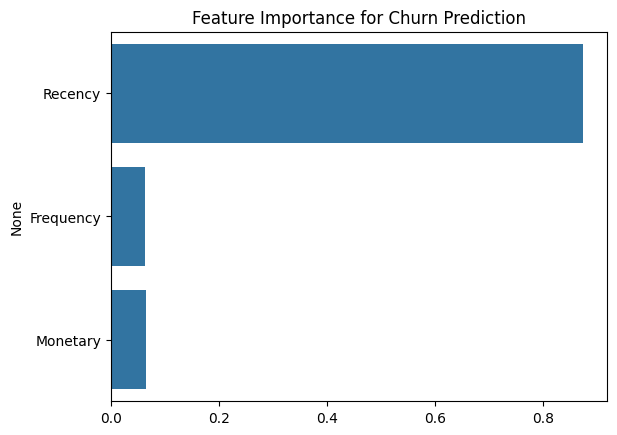

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
# Features (inputs)
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Target (output)
y = rfm['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Feature importance
importances = rf_model.feature_importances_
features = X.columns

sns.barplot(x=importances, y=features)
plt.title("Feature Importance for Churn Prediction")
plt.show()


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize model
model = RandomForestClassifier(random_state=42)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      1.00      1.00       172

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868



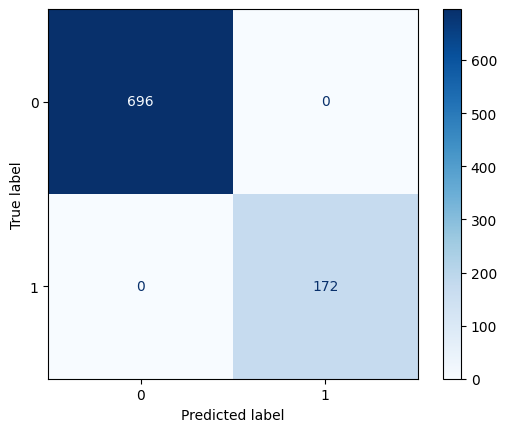

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')


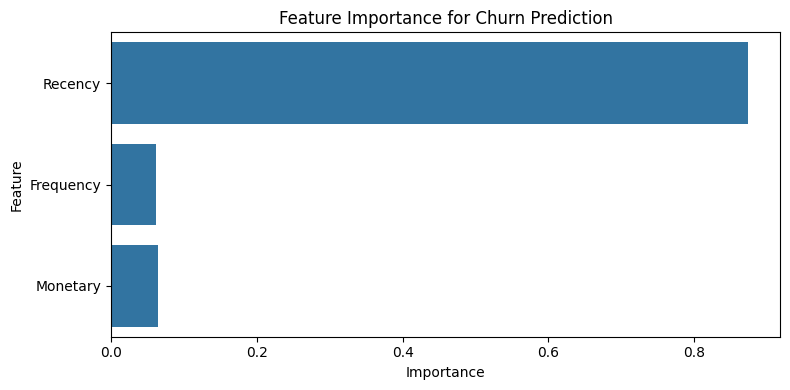

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importances
importances = model.feature_importances_
features = X.columns

# Create DataFrame for plotting
feat_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=feat_df, x='Importance', y='Feature')  # Removed palette
plt.title("Feature Importance for Churn Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [65]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier()

In [66]:
import pickle
with open("rf_model.pkl", "wb") as f:
    pickle.dump(model, f)


In [67]:
import pickle
import streamlit as st

try:
    with open("rf_model.pkl", "rb") as f:
        model = pickle.load(f)
except Exception as e:
    st.error(f"Error loading model: {e}")


In [35]:
print(rfm.columns)


Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Churn'], dtype='object')


In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale the RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [50]:
rfm.to_csv("rfm_with_clusters.csv", index=False)
print("Saved successfully.")


Saved successfully.


In [74]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


In [76]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Make sure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate TotalAmount if missing
if 'TotalAmount' not in df.columns:
    df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Snapshot date for recency calculation
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM Aggregation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Remove negative monetary values if any (due to cancellations)
rfm = rfm[rfm['Monetary'] > 0]

# Scale the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Final processed DataFrame
rfm_df = rfm.copy()

# Optional: Save it
rfm_df.to_csv("rfm_clustered.csv", index=False)
print("RFM DataFrame with KMeans Clusters saved as 'rfm_clustered.csv'")


RFM DataFrame with KMeans Clusters saved as 'rfm_clustered.csv'


In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Save processed df
rfm_df = rfm.copy()


In [78]:
rfm_df.to_csv("rfm_clustered.csv", index=False)
print("Processed RFM DataFrame with Clusters saved as 'rfm_clustered.csv'")


Processed RFM DataFrame with Clusters saved as 'rfm_clustered.csv'


In [79]:
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

# Dropdown widget for selecting cluster
cluster_selector = widgets.Dropdown(
    options=sorted(rfm_df['Cluster'].unique()),
    description='Cluster:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Function to plot RFM distribution for a selected cluster
def plot_cluster_distribution(selected_cluster):
    filtered = rfm_df[rfm_df['Cluster'] == selected_cluster]
    
    fig1 = px.histogram(filtered, x='Recency', nbins=30, title=f"Recency - Cluster {selected_cluster}")
    fig2 = px.histogram(filtered, x='Frequency', nbins=30, title=f"Frequency - Cluster {selected_cluster}")
    fig3 = px.histogram(filtered, x='Monetary', nbins=30, title=f"Monetary - Cluster {selected_cluster}")
    
    fig1.show()
    fig2.show()
    fig3.show()

# Interact using the dropdown
widgets.interact(plot_cluster_distribution, selected_cluster=cluster_selector)


interactive(children=(Dropdown(description='Cluster:', layout=Layout(width='300px'), options=(0, 1, 2, 3), sty…

<function __main__.plot_cluster_distribution(selected_cluster)>